In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from utils.metrics import mar, far, f1_score

from keras.models import Sequential, Model
from keras.layers import TimeDistributed, Input, Dense, LSTM, RepeatVector

In [2]:
from ipywidgets import IntProgress
from IPython.display import display

In [3]:
df = pd.read_csv("./data/valve1/0.csv", sep=";", parse_dates=True, index_col="datetime")

df.sort_index(inplace=True)
df.head()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 10:14:33,0.026588,0.040111,1.33020,0.054711,79.3366,26.0199,233.062,32.0,0.0,0.0
2020-03-09 10:14:34,0.026170,0.040453,1.35399,0.382638,79.5158,26.0258,236.040,32.0,0.0,0.0
2020-03-09 10:14:35,0.026199,0.039419,1.54006,0.710565,79.3756,26.0265,251.380,32.0,0.0,0.0
2020-03-09 10:14:36,0.026027,0.039641,1.33458,0.382638,79.6097,26.0393,234.392,32.0,0.0,0.0
2020-03-09 10:14:37,0.026290,0.040273,1.07851,-0.273216,79.6109,26.0420,225.342,32.0,0.0,0.0


In [4]:
train_size = 400

In [5]:
SS = StandardScaler()
x_train = np.array(SS.fit_transform(df[:train_size].drop(['anomaly','changepoint'], axis=1)))

In [6]:
TIME_STEPS = 50

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

x_train = create_sequences(x_train)
print("Training input shape: ", x_train.shape)

Training input shape:  (351, 50, 8)


In [7]:
n_features = x_train.shape[-1]
window_shape = (TIME_STEPS, n_features)


encoder_input = Input(shape = (None, n_features))
encoder_LSTM = LSTM(128, return_state = True)
_, encoder_h, encoder_c = encoder_LSTM(encoder_input)
encoder_states = [encoder_h, encoder_c]

decoder_input = Input(shape = (None, n_features))
decoder_LSTM = LSTM(128, return_sequences = True, return_state = True)
decoder_out, _, _ = decoder_LSTM(decoder_input, initial_state = encoder_states)
decoder_dense = TimeDistributed(Dense(n_features, activation = "relu"))
decoder_out = decoder_dense(decoder_out)

model = Model(inputs=[encoder_input, decoder_input], outputs=[decoder_out])
model.compile(optimizer='adam', loss='mse')

model.fit(x=[x_train, x_train], y=x_train, batch_size=32 , epochs=2)

Epoch 1/2
11/11 [==============================] - 7s 91ms/step - loss: 0.8930
Epoch 2/2
11/11 [==============================] - 1s 83ms/step - loss: 0.7772


In [8]:
encoder_model_inf = Model(encoder_input, encoder_states)

In [9]:
decoder_state_input_h = Input(shape = (128, ))
decoder_state_input_c = Input(shape = (128, ))
decoder_input_states = [decoder_state_input_h, decoder_state_input_c]

decoder_out, decoder_h, decoder_c = decoder_LSTM(decoder_input, initial_state = decoder_input_states)
decoder_states = [decoder_h, decoder_c]
decoder_out = decoder_dense(decoder_out)

decoder_model_inf = Model(inputs = [decoder_input] + decoder_input_states,
                          outputs = [decoder_out] + decoder_states)

In [10]:
x_test = np.array(SS.transform(df.drop(['anomaly','changepoint'], axis=1)))
x_test = create_sequences(x_test)

print("Testing input shape: ", x_test.shape)

Testing input shape:  (1098, 50, 8)


In [11]:
# def decode_window(w):
#     encoder

In [12]:
start_symbol = -1 * np.ones(n_features) # символ начала последовательности для декодера

In [13]:
encoded_windows = encoder_model_inf.predict(x_test)
encoded_windows = np.array(encoded_windows)
encoded_windows.shape

(2, 1098, 128)

In [14]:
predictions = []
bar = IntProgress(
        min=0, max=len(x_test), 
        description=f"Computing", style={'bar_color': '#61dc8a'},)

display(bar)
    
for win_no, window in enumerate(x_test):
    h, c = encoded_windows[:, win_no, :]
    h = np.reshape(h, (1,len(h)))
    c = np.reshape(c, (1,len(c)))
    
    window[0] = start_symbol    
    window = np.reshape(window, (1, TIME_STEPS, n_features))
    
    decoder_out, decoder_h, decoder_c = decoder_model_inf.predict([window,h,c])

    predictions.append(decoder_out[0])
    bar.value +=1

IntProgress(value=0, description='Computing', max=1098, style=ProgressStyle(bar_color='#61dc8a'))

In [15]:
predictionsa = np.array(predictions)
# predictionsa.shape, len(predictions)
# predictionsa.shape
x_test.shape

(1098, 50, 8)

In [16]:
r = pd.Series(np.sum(np.mean(np.abs(np.array(predictions) - x_test), axis=1), axis=1))

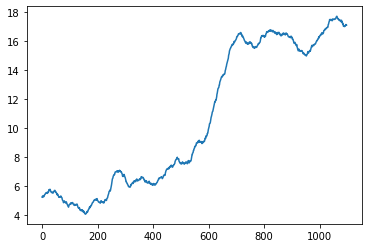

In [17]:
plt.plot(r)
plt.show()

In [18]:
Q = 0.99
health_r = r[:train_size]
UCL = health_r.quantile(Q)

In [19]:
anomalous_data = r > (3/2 * UCL)
anomalous_data_indices = [] 
for data_idx in range(TIME_STEPS - 1, len(x_test) - TIME_STEPS + 1):
    if np.all(anomalous_data[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx - int(TIME_STEPS // 6))

In [20]:
prediction = pd.Series(data=0, index=df.index)
prediction.iloc[anomalous_data_indices] = 1

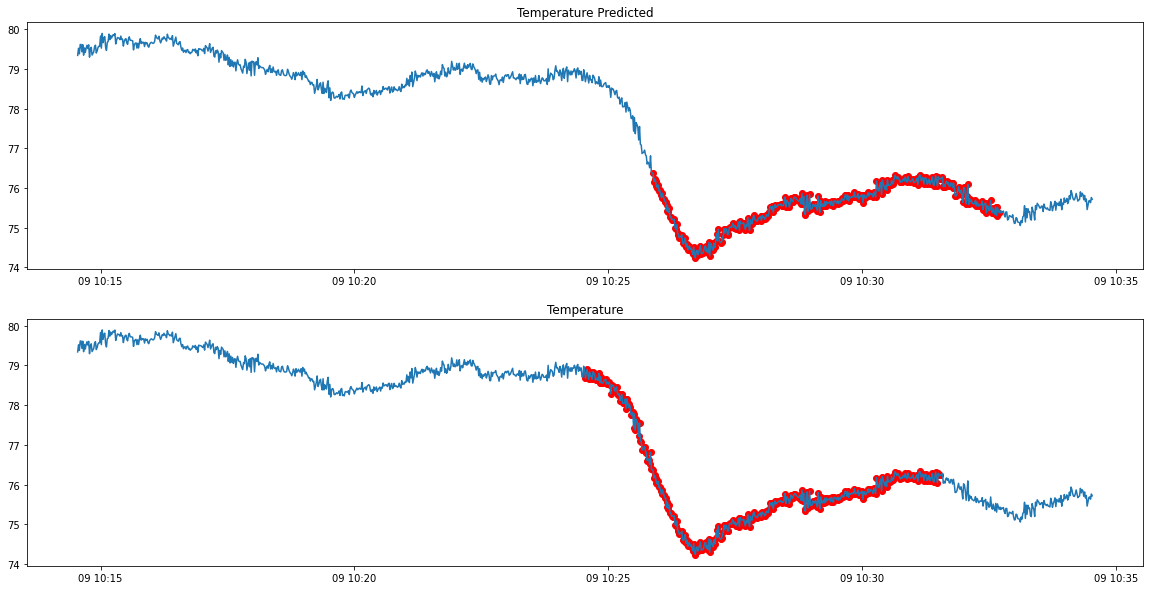

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(20,10))
temperatures = df.Temperature
axs[0].plot(temperatures)
axs[1].plot(temperatures)

y = pd.Series(prediction)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(anomalies_indecies, temperatures[anomalies_indecies], color='r')
axs[0].set_title("Temperature Predicted")

y = pd.Series(df.anomaly)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], temperatures[anomalies_indecies], color='r')
axs[1].set_title("Temperature")

plt.show()

In [22]:
print(f"""F1 = {f1_score(df.anomaly, prediction)}
FAR = {far(df.anomaly, prediction)}
MAR = {mar(df.anomaly, prediction)}""")

F1 = 0.819672131147541
FAR = 0.08981233243967829
MAR = 0.18952618453865336
